In [22]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import joblib
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
raw_features = 520

In [24]:
# === Step 1: Load data ===
df = pd.read_excel('1. Dataset UJIIndoorloc.xlsx')  # Replace with your actual filename
# Load test data
DT = pd.read_excel('1. Datatest UJIIndoorloc.xlsx')  # unseen data

# Data Normalization

In [25]:
# Sigmoid-Scaled Row Normalization

# === Step 1: Select RSSI columns ===
rssi_columns = df.columns[:raw_features]

# === Step 2: Replace 100 (no signal) with 0 ===
df[rssi_columns] = df[rssi_columns].replace(100, 0)

# === Step 3: Shift RSSI to positive (only non-zero) ===
rssi_min = df[rssi_columns][df[rssi_columns] < 0].min().min()
shift = rssi_min - 1  # shift negative RSSI to positive
df[rssi_columns] = df[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)

# === Step 4: Row-wise normalization (exclude zeros) ===
row_max = df[rssi_columns].replace(0, pd.NA).max(axis=1)
df[rssi_columns] = df[rssi_columns].div(row_max, axis=0).fillna(0)

# === Step 5: Apply sigmoid transformation to non-zero values ===
alpha = 10  # steepness of sigmoid
beta = 0.5  # midpoint
df[rssi_columns] = df[rssi_columns].applymap(
    lambda x: 1 / (1 + np.exp(-alpha * (x - beta))) if x > 0 else 0
)

C:\Users\KMITL\AppData\Local\Temp\ipykernel_28532\4252080208.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[rssi_columns] = df[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)
C:\Users\KMITL\AppData\Local\Temp\ipykernel_28532\4252080208.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rssi_columns] = df[rssi_columns].div(row_max, axis=0).fillna(0)
C:\Users\KMITL\AppData\Local\Temp\ipykernel_28532\4252080208.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[rssi_columns] = df[rssi_columns].applymap(


In [26]:
# Sigmoid-Scaled Row Normalization

# === Step 1: Replace 100 (no signal) with 0 ===
DT[rssi_columns] = DT[rssi_columns].replace(100, 0)

# === Step 2: Shift RSSI using dataset-wide min (from training) ===
shift = rssi_min - 1
DT[rssi_columns] = DT[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)

# === Step 3: Row-wise normalization (exclude zeros) ===
row_max = DT[rssi_columns].replace(0, np.nan).max(axis=1)
DT[rssi_columns] = DT[rssi_columns].div(row_max, axis=0).fillna(0)

# === Step 4: Apply sigmoid transformation ===
alpha = 10  # steepness of the sigmoid
beta = 0.5  # midpoint
DT[rssi_columns] = DT[rssi_columns].applymap(
    lambda x: 1 / (1 + np.exp(-alpha * (x - beta))) if x > 0 else 0
)

C:\Users\KMITL\AppData\Local\Temp\ipykernel_28532\4082890510.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DT[rssi_columns] = DT[rssi_columns].applymap(lambda x: x - shift if x < 0 else 0)
C:\Users\KMITL\AppData\Local\Temp\ipykernel_28532\4082890510.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DT[rssi_columns] = DT[rssi_columns].applymap(


# Marking Floor ID

In [27]:
# Initialization
order = 0
building_id = 0
floor_id = 0
order_ = []

# Loop through the sorted DataFrame
for i in range(len(df)):
    # Check if the current coordinates are the same as the previous coordinates
    if df.iloc[i, -2] == building_id and df.iloc[i, -3] == floor_id:
        # Append the same order if the coordinates are the same
        order_.append(order)
    else:
        # If new coordinates, increment the order and update x, y, z
        building_id = df.iloc[i, -2]
        floor_id = df.iloc[i, -3]
        order += 1
        order_.append(order)

# Adding the computed order back to the DataFrame
df['FLOOR_ID'] = order_
df

C:\Users\KMITL\AppData\Local\Temp\ipykernel_28532\1629925467.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['FLOOR_ID'] = order_


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,Order,FLOOR_ID
0,0.0,0.0,0,0,0.0,0.0,0.298666,0.0,0.0,0.0,...,0.000000,0.0,0.0,0,-7685.7235,4.864930e+06,0,0,1,0
1,0.0,0.0,0,0,0.0,0.0,0.197816,0.0,0.0,0.0,...,0.000000,0.0,0.0,0,-7685.7235,4.864930e+06,0,0,1,0
2,0.0,0.0,0,0,0.0,0.0,0.242989,0.0,0.0,0.0,...,0.000000,0.0,0.0,0,-7685.7235,4.864930e+06,0,0,1,0
3,0.0,0.0,0,0,0.0,0.0,0.222700,0.0,0.0,0.0,...,0.000000,0.0,0.0,0,-7685.7235,4.864930e+06,0,0,1,0
4,0.0,0.0,0,0,0.0,0.0,0.252192,0.0,0.0,0.0,...,0.000000,0.0,0.0,0,-7685.7235,4.864930e+06,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,0.0,0.0,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.841131,0.0,0.0,0,-7309.5175,4.864813e+06,4,2,932,12
19933,0.0,0.0,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.841131,0.0,0.0,0,-7309.5175,4.864813e+06,4,2,932,12
19934,0.0,0.0,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.841131,0.0,0.0,0,-7309.5175,4.864813e+06,4,2,932,12
19935,0.0,0.0,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.841131,0.0,0.0,0,-7309.5175,4.864813e+06,4,2,932,12


In [28]:
# Initialization
order = 0
building_id = 0
floor_id = 0
order_ = []

# Loop through the sorted DataFrame
for i in range(len(DT)):
    # Check if the current coordinates are the same as the previous coordinates
    if DT.iloc[i, -1] == building_id and DT.iloc[i, -2] == floor_id:
        # Append the same order if the coordinates are the same
        order_.append(order)
    else:
        # If new coordinates, increment the order and update x, y, z
        building_id = DT.iloc[i, -1]
        floor_id = DT.iloc[i, -2]
        order += 1
        order_.append(order)

# Adding the computed order back to the DataFrame
DT['FLOOR_ID'] = order_
DT

C:\Users\KMITL\AppData\Local\Temp\ipykernel_28532\1386778111.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DT['FLOOR_ID'] = order_


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,FLOOR_ID
0,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,-7680.015484,4.864931e+06,0,0,0
1,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,-7639.400495,4.864913e+06,0,0,0
2,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,-7632.777600,4.864965e+06,0,0,0
3,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,-7607.076600,4.864978e+06,0,0,0
4,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,-7592.953185,4.864984e+06,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,-7352.064178,4.864835e+06,4,2,12
1107,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,-7337.775408,4.864827e+06,4,2,12
1108,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,-7324.144263,4.864818e+06,4,2,12
1109,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,-7316.901654,4.864815e+06,4,2,12


In [29]:
X = df.iloc[:,:520]
X_target = DT.iloc[:,:520]

y_building = df.iloc[:, -3]
y_floor = df.iloc[:, -1]
y_coordinate = df.iloc[:, [-6,-5]]
y_target_building = DT.iloc[:,-2]
y_target_floor = DT.iloc[:,-1]
y_target_coordinate = DT.iloc[:, [-5,-4]]

# Important Features

In [30]:
# Confidence weighting using Pearson correlation

# Step 6.1: Compute Pearson correlations between each feature and target
correlations = X.apply(lambda x: x.corr(y_floor), axis=0)

# Step 6.2: Replace NaN with 0 (e.g. for constant columns)
correlations = correlations.fillna(0)

# Step 6.3: Compute confidence weights (e.g., absolute correlation)
confidence_weights = correlations.abs()

# Optional: scale weights to [0, 1]
confidence_weights = confidence_weights / confidence_weights.max()

# Step 6.4: Multiply each feature by its confidence weight
X_weighted = X.mul(confidence_weights, axis=1)

C:\Users\KMITL\anaconda3\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\KMITL\anaconda3\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [31]:
# Confidence weighting using Pearson correlation

# Step 6.5: Remove all-zero columns (optional cleanup)
X_weighted_cleaned = X_weighted.loc[:, (X_weighted != 0).any(axis=0)]

# Step 6.6: Update feature count
raw_features = X_weighted_cleaned.shape[1]

# Result: X_weighted_cleaned has transformed, normalized, and confidence-weighted features
X_weighted_cleaned

,WAP001,WAP002,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,...,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519
0,0.0,0.0,0.0,0.0,0.143402,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.094980,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.116669,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.106927,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.121088,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.544021,0.0,0.0,0.0,0.0,0.0,0.810542,0.0,0.0
19933,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.544021,0.0,0.0,0.0,0.0,0.0,0.810542,0.0,0.0
19934,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.544021,0.0,0.0,0.0,0.0,0.0,0.810542,0.0,0.0
19935,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.544021,0.0,0.0,0.0,0.0,0.0,0.810542,0.0,0.0


In [32]:
# Confidence weighting using Pearson correlation

# Step 2: Apply the same weights to X_target
X_target_weighted = X_target.mul(confidence_weights, axis=1)

# Step 3: Keep only the columns that were kept in training
X_target_weighted_cleaned = X_target_weighted[X_weighted_cleaned.columns]

X_target_weighted_cleaned

,WAP001,WAP002,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,...,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507841,0.507425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054563,0.044950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
X = X_weighted_cleaned
X_target = X_target_weighted_cleaned 

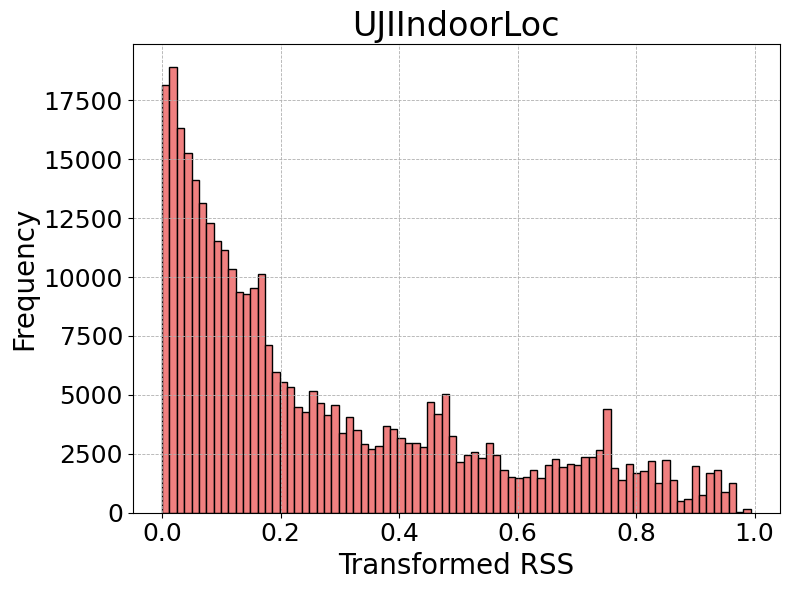

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
#raw_features = 992
#df = pd.read_excel('2. Dataset Tampere.xlsx')
#X = df.iloc[:, :raw_features]

# Flatten all values into a single array
all_values = X.values.flatten()

# Remove NaNs and values equal to 100
all_values = all_values[~pd.isnull(all_values)]
all_values = all_values[all_values != 0]

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

# Histogram
ax.hist(all_values, bins=80, color='lightcoral', edgecolor='black', zorder=1)

# Grid behind
ax.grid(True, linestyle='--', linewidth=0.6, zorder=1)

# Titles and labels
ax.set_title("UJIIndoorLoc", fontsize=24)
ax.set_xlabel("Transformed RSS", fontsize=20)
ax.set_ylabel("Frequency", fontsize=20)

# ✅ Adjust tick font sizes
ax.tick_params(axis='both', labelsize=18)
plt.tight_layout()
plt.savefig('Transformed UJIIndoorLoc distribution.svg', dpi = 600)
plt.show()

# Building Prediction

In [35]:
import optuna
import random
import numpy as np
from optuna.exceptions import TrialPruned
from optuna.integration import LightGBMPruningCallback
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [36]:
# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_building, test_size=0.2, random_state=42)

# --- Fix random seeds for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [37]:
import time

start_time1 = time.time()

# --- Custom weight function for KNN ---
def knn_weight(d):
    return 1 / (d + 0.000001) ** 2


# --- Objective function for KNN ---
def objective_wknn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan'])

    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=knn_weight,
        p=p,
        metric=metric
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(scores)


# --- Objective function for RandomForest ---
def objective_rf(trial):
    max_depth = trial.suggest_categorical('max_depth', [None] + list(range(5, 51)))
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    rf = RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=SEED,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        rf.fit(X_tr, y_tr)
        y_pred = rf.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(scores)


# --- Objective function for LightGBM (with pruning callback) ---
def objective_lgb(trial):
    param = {
    'n_estimators': 10000,
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
    'num_leaves': trial.suggest_int('num_leaves', 20, 100),
    'max_depth': trial.suggest_int('max_depth', 3, 30),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    'random_state': SEED,
    'n_jobs': -1,
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'verbosity': -1}


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    model = lgb.LGBMClassifier(**param)

    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_error',
            callbacks=[lgb.early_stopping(100)],
        )

        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        # Report accuracy to Optuna for pruning
        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(scores)

# --- Objective function for XGBoost ---
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'random_state': SEED,
        'n_jobs': -1
    }

    model = XGBClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(scores)


# --- Objective function for GaussianNB ---
def objective_gnb(trial):
    param = {
        'var_smoothing': trial.suggest_loguniform('var_smoothing', 1e-12, 1e-6)
    }

    model = GaussianNB(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(scores)


from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from optuna.exceptions import TrialPruned

# --- Objective function for AdaBoost ---
def objective_adaboost(trial):
    base_estimator_params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'random_state': SEED
    }

    # AdaBoost-specific hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)

    base_estimator = DecisionTreeClassifier(**base_estimator_params)

    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=SEED
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(scores)

In [38]:
# KNN
# --- Run the optimization ---
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective_wknn, n_trials=100, timeout=300)

# --- Get best parameters ---
best_params1 = study1.best_params
print("Best KNN hyperparameters:", best_params1)

# --- Train final model ---
knn_building_final = KNeighborsClassifier(
    n_neighbors=best_params1['n_neighbors'],
    weights=knn_weight,
    p=best_params1['p'],
    metric=best_params1['metric']
)

# --- Cross-validation accuracy ---
cv_scores_knn = cross_val_score(knn_building_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("KNN Cross-val Accuracies:", cv_scores_knn)
print("KNN Mean CV Accuracy:", cv_scores_knn.mean())

# --- Train on full training set (optional, if you want to save the model) ---
knn_building_final.fit(X_train, y_train)
joblib.dump(knn_building_final, 'knn_building_UJI.joblib')

[I 2025-12-22 09:01:06,359] A new study created in memory with name: no-name-2b9788f0-a3ac-4d0c-8741-03289e7070ec
[I 2025-12-22 09:01:14,277] Trial 0 finished with value: 0.9976173975784708 and parameters: {'n_neighbors': 14, 'p': 3, 'metric': 'manhattan'}. Best is trial 0 with value: 0.9976173975784708.
[I 2025-12-22 09:01:15,725] Trial 1 finished with value: 0.9954229222513519 and parameters: {'n_neighbors': 36, 'p': 5, 'metric': 'euclidean'}. Best is trial 0 with value: 0.9976173975784708.
[I 2025-12-22 09:02:33,375] Trial 2 finished with value: 0.9946705514941152 and parameters: {'n_neighbors': 45, 'p': 4, 'metric': 'minkowski'}. Best is trial 0 with value: 0.9976173975784708.
[I 2025-12-22 09:02:34,817] Trial 3 finished with value: 0.9961126167438815 and parameters: {'n_neighbors': 27, 'p': 4, 'metric': 'euclidean'}. Best is trial 0 with value: 0.9976173975784708.
[I 2025-12-22 09:02:42,936] Trial 4 finished with value: 0.9970530949354709 and parameters: {'n_neighbors': 39, 'p': 3

Best KNN hyperparameters: {'n_neighbors': 1, 'p': 1, 'metric': 'manhattan'}
KNN Cross-val Accuracies: [1.         0.99874608 0.99811912 0.99874608 0.99561129 0.99937304
 0.99749216 0.9968652  0.99811912 0.99874529]
KNN Mean CV Accuracy: 0.9981817395169189


['knn_building_UJI.joblib']

In [39]:
# Random Forest
# --- Run the optimization ---
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective_rf, n_trials=100, timeout=300)

# --- Train final model with best hyperparameters ---
best_params2 = study2.best_params
print("Best Random Forest hyperparameters:", best_params2)

rf_building_final = RandomForestClassifier(
    **best_params2,
    random_state=SEED,
    n_jobs=-1
)

# --- Cross-validation accuracy ---
cv_scores_rf = cross_val_score(rf_building_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("RF Cross-val Accuracies:", cv_scores_rf)
print("RF Mean CV Accuracy:", cv_scores_rf.mean())

# --- Train on full training set (optional, if you want to save the model) ---
rf_building_final.fit(X_train, y_train)
joblib.dump(rf_building_final, 'rf_building_pred_UJI.joblib')

[I 2025-12-22 09:06:25,292] A new study created in memory with name: no-name-17acb02d-b65c-4a64-af42-83305bc58e2d
[I 2025-12-22 09:06:31,955] Trial 0 finished with value: 0.9980562887118829 and parameters: {'max_depth': 45, 'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.9980562887118829.
[I 2025-12-22 09:06:35,038] Trial 1 finished with value: 0.9910338929568825 and parameters: {'max_depth': 10, 'n_estimators': 224, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9980562887118829.
[I 2025-12-22 09:06:53,587] Trial 2 finished with value: 0.9675215842861089 and parameters: {'max_depth': 9, 'n_estimators': 446, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 0 with value: 0.9980562887118829.
[I 2025-12-22 09:06:55,509] Trial 3 finished with value: 0.9963634790831728 and parameters: {'max_depth': 10, 'n_estimators': 134, 'min_sam

Best Random Forest hyperparameters: {'max_depth': 45, 'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}
RF Cross-val Accuracies: [0.99749216 0.99874608 0.9968652  0.99874608 0.99561129 0.99937304
 0.99623824 0.9968652  0.99561129 0.99874529]
RF Mean CV Accuracy: 0.9974293884197403


['rf_building_pred_UJI.joblib']

In [40]:
# Run Optuna study
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective_lgb, n_trials=100, timeout=300)

# Best params
best_params3 = study3.best_params
print("Best LightGBM hyperparameters:", best_params3)

best_params3.update({
    'random_state': SEED,
    'n_jobs': -1,
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train))
})

# Final model
lgb_building_final = lgb.LGBMClassifier(**best_params3)

# Cross-validation
cv_scores_lgb = cross_val_score(lgb_building_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("LGB Cross-val Accuracies:", cv_scores_lgb)
print("LGB Mean CV Accuracy:", cv_scores_lgb.mean())

# Train final model
lgb_building_final.fit(X_train, y_train)

# Save
joblib.dump(lgb_building_final, 'lgb_building_pred_UJI.joblib')

[I 2025-12-22 09:11:39,407] A new study created in memory with name: no-name-5893638d-f5d9-4697-a001-ad581033624c


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.147705
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's multi_error: 0.000940439	valid_0's multi_logloss: 0.00533039
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	valid_0's multi_error: 0.00125392	valid_0's multi_logloss: 0.0064329
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's multi_error: 0.0015674	valid_0's multi_logloss: 0.0079243
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:12:10,659] Trial 0 finished with value: 0.9984325035805881 and parameters: {'learning_rate': 0.05578769143281918, 'num_leaves': 80, 'max_depth': 26, 'min_child_samples': 35}. Best is trial 0 with value: 0.9984325035805881.


Early stopping, best iteration is:
[75]	valid_0's multi_error: 0.00156789	valid_0's multi_logloss: 0.00728177
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[175]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0854071
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[534]	valid_0's multi_error: 0.000940439	valid_0's multi_logloss: 0.00453757
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[154]	valid_0's multi_error: 0.00376176	valid_0's multi_logloss: 0.112952
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	valid_0's multi_error: 0.00282132	valid_0's multi_logloss: 0.0793313
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	valid_0's multi_error: 0.00156789	valid_0's multi_logloss: 0.00714786


[I 2025-12-22 09:13:30,403] Trial 1 finished with value: 0.9976801524834095 and parameters: {'learning_rate': 0.010567435071746279, 'num_leaves': 93, 'max_depth': 25, 'min_child_samples': 76}. Best is trial 0 with value: 0.9984325035805881.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.00848125
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0104695
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[191]	valid_0's multi_error: 0.00219436	valid_0's multi_logloss: 0.0143694
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[289]	valid_0's multi_error: 0.0015674	valid_0's multi_logloss: 0.00530958
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:14:11,867] Trial 2 finished with value: 0.9975546426735319 and parameters: {'learning_rate': 0.018835756470339235, 'num_leaves': 58, 'max_depth': 12, 'min_child_samples': 38}. Best is trial 0 with value: 0.9984325035805881.


Early stopping, best iteration is:
[38]	valid_0's multi_error: 0.00344936	valid_0's multi_logloss: 0.349567
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's multi_error: 0.0031348	valid_0's multi_logloss: 0.0318443
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	valid_0's multi_error: 0.000940439	valid_0's multi_logloss: 0.00505128
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_error: 0.00125392	valid_0's multi_logloss: 0.00722903
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_error: 0.0015674	valid_0's multi_logloss: 0.00463732
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:14:19,201] Trial 3 finished with value: 0.9983071117310583 and parameters: {'learning_rate': 0.41789290050075306, 'num_leaves': 35, 'max_depth': 29, 'min_child_samples': 69}. Best is trial 0 with value: 0.9984325035805881.


Early stopping, best iteration is:
[7]	valid_0's multi_error: 0.00156789	valid_0's multi_logloss: 0.0203423
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	valid_0's multi_error: 0.00219436	valid_0's multi_logloss: 0.0138893
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0122826
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	valid_0's multi_error: 0.00125392	valid_0's multi_logloss: 0.00371731
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00571698
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:14:29,985] Trial 4 finished with value: 0.9981190239567637 and parameters: {'learning_rate': 0.07352559767674131, 'num_leaves': 95, 'max_depth': 4, 'min_child_samples': 19}. Best is trial 0 with value: 0.9984325035805881.


Early stopping, best iteration is:
[174]	valid_0's multi_error: 0.00156789	valid_0's multi_logloss: 0.00407107
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0613096
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	valid_0's multi_error: 0.000940439	valid_0's multi_logloss: 0.00418177
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	valid_0's multi_error: 0.00125392	valid_0's multi_logloss: 0.00421275
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	valid_0's multi_error: 0.0015674	valid_0's multi_logloss: 0.00567119
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:15:13,219] Trial 5 finished with value: 0.9984325035805881 and parameters: {'learning_rate': 0.02724170837436886, 'num_leaves': 75, 'max_depth': 14, 'min_child_samples': 50}. Best is trial 0 with value: 0.9984325035805881.


Early stopping, best iteration is:
[190]	valid_0's multi_error: 0.00156789	valid_0's multi_logloss: 0.00483455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.298239
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:15:30,130] Trial 6 pruned. 


Early stopping, best iteration is:
[186]	valid_0's multi_error: 0.00282132	valid_0's multi_logloss: 0.0317646
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's multi_error: 0.00219436	valid_0's multi_logloss: 0.0109958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_error: 0.000940439	valid_0's multi_logloss: 0.003678
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's multi_error: 0.00125392	valid_0's multi_logloss: 0.00365544
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00473423
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:15:37,449] Trial 7 finished with value: 0.9984325035805881 and parameters: {'learning_rate': 0.21560451228311736, 'num_leaves': 27, 'max_depth': 5, 'min_child_samples': 15}. Best is trial 0 with value: 0.9984325035805881.


Early stopping, best iteration is:
[44]	valid_0's multi_error: 0.00156789	valid_0's multi_logloss: 0.00419664
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's multi_error: 0.00219436	valid_0's multi_logloss: 0.00758711
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_error: 0.000940439	valid_0's multi_logloss: 0.00418865
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's multi_error: 0.00125392	valid_0's multi_logloss: 0.00414535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_error: 0.0015674	valid_0's multi_logloss: 0.00528366
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:15:48,665] Trial 8 finished with value: 0.998495199505353 and parameters: {'learning_rate': 0.16114592325856952, 'num_leaves': 57, 'max_depth': 11, 'min_child_samples': 64}. Best is trial 8 with value: 0.998495199505353.


Early stopping, best iteration is:
[34]	valid_0's multi_error: 0.00156789	valid_0's multi_logloss: 0.00461244
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	valid_0's multi_error: 0.00219436	valid_0's multi_logloss: 0.0156933
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:15:56,410] Trial 9 pruned. 


Early stopping, best iteration is:
[260]	valid_0's multi_error: 0.00282132	valid_0's multi_logloss: 0.0178516
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0289176
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_error: 0.000940439	valid_0's multi_logloss: 0.00408959
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's multi_error: 0.00125392	valid_0's multi_logloss: 0.00400837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_error: 0.0015674	valid_0's multi_logloss: 0.0047846
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:16:06,168] Trial 10 finished with value: 0.9984325035805881 and parameters: {'learning_rate': 0.141699076661194, 'num_leaves': 51, 'max_depth': 9, 'min_child_samples': 97}. Best is trial 8 with value: 0.998495199505353.


Early stopping, best iteration is:
[43]	valid_0's multi_error: 0.00156789	valid_0's multi_logloss: 0.00470922
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0753741
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's multi_error: 0.000940439	valid_0's multi_logloss: 0.00425326
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	valid_0's multi_error: 0.00125392	valid_0's multi_logloss: 0.00492402
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	valid_0's multi_error: 0.0015674	valid_0's multi_logloss: 0.00484849
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:16:33,688] Trial 11 finished with value: 0.9984325035805881 and parameters: {'learning_rate': 0.05958526825719909, 'num_leaves': 67, 'max_depth': 20, 'min_child_samples': 43}. Best is trial 8 with value: 0.998495199505353.


Early stopping, best iteration is:
[78]	valid_0's multi_error: 0.00156789	valid_0's multi_logloss: 0.00572645
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_error: 0.00219436	valid_0's multi_logloss: 0.0463965
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's multi_error: 0.000940439	valid_0's multi_logloss: 0.0044562
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's multi_error: 0.00125392	valid_0's multi_logloss: 0.00495753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's multi_error: 0.0015674	valid_0's multi_logloss: 0.00676047
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:16:54,842] Trial 12 finished with value: 0.998495199505353 and parameters: {'learning_rate': 0.05633957226558867, 'num_leaves': 46, 'max_depth': 18, 'min_child_samples': 69}. Best is trial 8 with value: 0.998495199505353.


Early stopping, best iteration is:
[82]	valid_0's multi_error: 0.00156789	valid_0's multi_logloss: 0.00634292
Best LightGBM hyperparameters: {'learning_rate': 0.16114592325856952, 'num_leaves': 57, 'max_depth': 11, 'min_child_samples': 64}
LGB Cross-val Accuracies: [1.         0.99874608 0.99874608 0.99874608 0.99561129 0.99937304
 0.99811912 0.9968652  0.99811912 0.99874529]
LGB Mean CV Accuracy: 0.9983071313664487


['lgb_building_pred_UJI.joblib']

In [41]:
# XGBoost
# --- Run optimization ---
study4 = optuna.create_study(direction='maximize')
study4.optimize(objective_xgb, n_trials=100, timeout=300)

# --- Best parameters ---
best_params4 = study4.best_params
print("Best XGBoost hyperparameters:", best_params4)

# --- Train final model with best params ---
xgb_building_final = XGBClassifier(**best_params4, use_label_encoder=False, eval_metric='mlogloss', random_state=SEED, n_jobs=-1)

# --- Cross-validation accuracy ---
cv_scores_xgb = cross_val_score(xgb_building_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("XGB Cross-val Accuracies:", cv_scores_xgb)
print("XGB Mean CV Accuracy:", cv_scores_xgb.mean())

# --- Train on full training set (optional, if you want to save the model) ---
xgb_building_final.fit(X_train, y_train)
joblib.dump(xgb_building_final, 'xgb_building_pred_UJI.joblib')

[I 2025-12-22 09:17:13,916] A new study created in memory with name: no-name-78639073-2d5c-45fd-b73f-0c346703f0de
C:\Users\KMITL\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [09:17:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\KMITL\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [09:17:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\KMITL\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [09:17:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\x

Best XGBoost hyperparameters: {'n_estimators': 186, 'learning_rate': 0.11197268327281866, 'max_depth': 3, 'min_child_weight': 5.035948529392061, 'gamma': 0.3119709464782064, 'subsample': 0.8634630331081131, 'colsample_bytree': 0.5007622506357574}
XGB Cross-val Accuracies: [0.99749216 0.99874608 0.99561129 0.99937304 0.99749216 0.99937304
 0.9968652  0.9968652  0.9968652  0.99749059]
XGB Mean CV Accuracy: 0.9976173975291356


C:\Users\KMITL\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [09:22:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['xgb_building_pred_UJI.joblib']

In [42]:
# Gaussian Naive Bayes
# --- Run the optimization ---
study7 = optuna.create_study(direction='maximize')
study7.optimize(objective_gnb, n_trials=50, timeout=200)

# --- Train final model with best hyperparameters ---
best_params7 = study7.best_params
print("Best Naive Bayes hyperparameters:", best_params7)

gnb_building_final = GaussianNB(**best_params7)

# --- Cross-validation accuracy ---
cv_scores_gnb = cross_val_score(gnb_building_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("GNB Cross-val Accuracies:", cv_scores_gnb)
print("GNB Mean CV Accuracy:", cv_scores_gnb.mean())

# --- Train on full training set (optional, if you want to save the model) ---
gnb_building_final.fit(X_train, y_train)
joblib.dump(gnb_building_final, 'gnb_building_pred_UJI.joblib')

[I 2025-12-22 09:22:39,621] A new study created in memory with name: no-name-a03a815d-db65-4776-a1d7-5012b3b50752
C:\Users\KMITL\AppData\Local\Temp\ipykernel_28532\777657298.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'var_smoothing': trial.suggest_loguniform('var_smoothing', 1e-12, 1e-6)
[I 2025-12-22 09:22:40,597] Trial 0 finished with value: 0.9957991371200571 and parameters: {'var_smoothing': 2.1953424644592985e-12}. Best is trial 0 with value: 0.9957991371200571.
C:\Users\KMITL\AppData\Local\Temp\ipykernel_28532\777657298.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'var_smoothing': trial.suggest_loguniform('var_smoothing', 1e-12, 1e-6)
[I 2025-1

Best Naive Bayes hyperparameters: {'var_smoothing': 1.0857602273601716e-07}
GNB Cross-val Accuracies: [1.         0.99874608 0.99874608 0.99811912 0.99561129 0.99937304
 0.99811912 0.99623824 0.99749216 0.99874529]
GNB Mean CV Accuracy: 0.9981190435921541


['gnb_building_pred_UJI.joblib']

In [43]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import joblib

# --- Run the optimization ---
study_ab = optuna.create_study(direction='maximize')
study_ab.optimize(objective_adaboost, n_trials=100, timeout=300)

# --- Train final model with best hyperparameters ---
best_params_ab = study_ab.best_params
print("Best hyperparameters:", best_params_ab)

# Extract AdaBoost-specific parameters
ada_params = {
    'n_estimators': best_params_ab.pop('n_estimators'),
    'learning_rate': best_params_ab.pop('learning_rate'),
    'random_state': SEED
}

# Remaining params go to base estimator (DecisionTree)
base_estimator = DecisionTreeClassifier(**best_params_ab, random_state=SEED)

# Build final AdaBoost model
ab_building_final = AdaBoostClassifier(
    estimator=base_estimator,
    **ada_params
)

# --- Cross-validation accuracy ---
cv_scores_ab = cross_val_score(ab_building_final, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
print("AdaBoost Cross-val Accuracies:", cv_scores_ab)
print("AdaBoost Mean CV Accuracy:", cv_scores_ab.mean())

# --- Train on full training set (optional, if you want to save the model) ---
ab_building_final.fit(X_train, y_train)
joblib.dump(ab_building_final, 'adaboost_building_pred_UJI.joblib')

[I 2025-12-22 09:23:16,087] A new study created in memory with name: no-name-d283c608-875a-4fd0-972f-ca69c5881559
[I 2025-12-22 09:24:20,207] Trial 0 finished with value: 0.9199317402788385 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 3, 'n_estimators': 77, 'learning_rate': 0.016456285975838102}. Best is trial 0 with value: 0.9199317402788385.
[I 2025-12-22 09:26:43,818] Trial 1 finished with value: 0.9974293687843498 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 19, 'n_estimators': 197, 'learning_rate': 0.6335393631690206}. Best is trial 1 with value: 0.9974293687843498.
[I 2025-12-22 09:32:00,277] Trial 2 finished with value: 0.9982444158062934 and parameters: {'criterion': 'log_loss', 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'n_estimators': 271, 'learning_rate': 0.4635982177250387}. Best is trial 2 with value: 0.9982444158062934.


Best hyperparameters: {'criterion': 'log_loss', 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'n_estimators': 271, 'learning_rate': 0.4635982177250387}
AdaBoost Cross-val Accuracies: [1.         0.99874608 0.99874608 0.99874608 0.99561129 0.99937304
 0.99811912 0.9968652  0.99811912 0.99874529]
AdaBoost Mean CV Accuracy: 0.9983071313664487


['adaboost_building_pred_UJI.joblib']

In [44]:
models = [
        ("KNN", knn_building_final),
        ("RF", rf_building_final),
        ("LGB", lgb_building_final),
        ("XGB", xgb_building_final),
        ("NB", gnb_building_final),
        ("AB", ab_building_final)
    ]

accuracy_knn = cv_scores_knn.mean()
accuracy_rf = cv_scores_rf.mean()
accuracy_lgb = cv_scores_lgb.mean()
accuracy_xgb = cv_scores_xgb.mean()
accuracy_gnb = cv_scores_gnb.mean()
accuracy_ab = cv_scores_ab.mean()

In [45]:
import os
import joblib
import pickle
import sys
import tempfile

# ===== Utility functions =====
def model_disk_size_mb(model):
    """Serialized model size on disk (deployment footprint)"""
    with tempfile.NamedTemporaryFile(delete=False, suffix=".joblib") as tmp:
        joblib.dump(model, tmp.name)
        size_mb = os.path.getsize(tmp.name) / (1024 ** 2)
    os.remove(tmp.name)
    return size_mb


def model_ram_size_mb(model):
    """In-memory size (RAM footprint)"""
    return sys.getsizeof(pickle.dumps(model)) / (1024 ** 2)


# ===== Compute footprint =====
disk_sizes = {}
ram_sizes = {}

for name, model in models:
    disk_sizes[name] = model_disk_size_mb(model)
    ram_sizes[name] = model_ram_size_mb(model)

# ===== Total ensemble footprint =====
total_disk_mb = sum(disk_sizes.values())
total_ram_mb = sum(ram_sizes.values())

print("===== ENSEMBLE MEMORY FOOTPRINT =====")
for name in disk_sizes:
    print(f"{name}: Disk = {disk_sizes[name]:.2f} MB | RAM = {ram_sizes[name]:.2f} MB")

print("------------------------------------")
print(f"TOTAL ENSEMBLE DISK SIZE: {total_disk_mb:.2f} MB")
print(f"TOTAL ENSEMBLE RAM SIZE : {total_ram_mb:.2f} MB")

===== ENSEMBLE MEMORY FOOTPRINT =====
KNN: Disk = 56.71 MB | RAM = 56.71 MB
RF: Disk = 0.65 MB | RAM = 0.64 MB
LGB: Disk = 1.44 MB | RAM = 1.44 MB
XGB: Disk = 0.50 MB | RAM = 0.50 MB
NB: Disk = 0.03 MB | RAM = 0.03 MB
AB: Disk = 0.67 MB | RAM = 0.66 MB
------------------------------------
TOTAL ENSEMBLE DISK SIZE: 60.00 MB
TOTAL ENSEMBLE RAM SIZE : 59.98 MB


In [84]:
# IEO-CVV

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

def ieo_cvv_ensemble_selection(models, X_train, y_train, X_test, y_test, cv=10, patience=3):
    print("Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV)...")

    # --- Step 1: Compute cross-val scores and predictions ---
    model_scores = {}
    model_preds = {}

    for name, model in models:
        print(f"Evaluating {name}...")
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
        acc = cv_scores.mean()
        model_scores[name] = acc

        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv, method='predict', n_jobs=-1)
        model_preds[name] = y_pred_cv

        print(f"{name} CV Accuracy: {acc:.4f}")

    # Sort models by CV accuracy
    sorted_models = sorted(models, key=lambda m: model_scores[m[0]], reverse=True)

    # --- Ensemble voting function (CV-based predictions) ---
    def ensemble_predict_cv(selected_model_names):
        preds = np.array([model_preds[name] for name in selected_model_names])
        weights = np.array([model_scores[name] for name in selected_model_names])
        weighted_preds = []

        for i in range(preds.shape[1]):
            classes = np.unique(preds[:, i])
            vote_score = {c: 0.0 for c in classes}
            for j, c in enumerate(preds[:, i]):
                vote_score[c] += weights[j]
            final_class = max(vote_score, key=vote_score.get)
            weighted_preds.append(final_class)

        return np.array(weighted_preds)

    # --- Step 2: Initialize ensemble with top 2 models ---
    ensemble = sorted_models[:2]
    ensemble_names = [name for name, _ in ensemble]
    best_acc = accuracy_score(y_train, ensemble_predict_cv(ensemble_names))
    print(f"Initial Ensemble: {[n for n, _ in ensemble]} - Train Accuracy: {best_acc:.4f}")

    # --- Step 3: Iterative forward selection with backward pruning ---
    patience_counter = 0
    remaining_models = sorted_models[2:]

    while remaining_models and patience_counter < patience:
        improved = False

        name, model = remaining_models.pop(0)
        temp_ensemble = ensemble + [(name, model)]
        temp_names = [n for n, _ in temp_ensemble]

        y_pred_temp = ensemble_predict_cv(temp_names)
        new_acc = accuracy_score(y_train, y_pred_temp)

        if new_acc > best_acc:
            ensemble = temp_ensemble
            best_acc = new_acc
            improved = True
            patience_counter = 0
            print(f"Added {name} - Improved Train Accuracy: {new_acc:.4f}")

            # --- Backward pruning ---
            pruned = True
            while pruned and len(ensemble) > 1:
                pruned = False
                for n, m in ensemble:
                    if n == name:
                        continue  # Don't remove just-added model
                    temp_ensemble_pruned = [(x, y) for x, y in ensemble if x != n]
                    temp_names_pruned = [x for x, _ in temp_ensemble_pruned]
                    y_pred_pruned = ensemble_predict_cv(temp_names_pruned)
                    pruned_acc = accuracy_score(y_train, y_pred_pruned)

                    if pruned_acc >= best_acc:
                        print(f"Pruned {n} - Accuracy maintained/improved: {pruned_acc:.4f}")
                        ensemble = temp_ensemble_pruned
                        best_acc = pruned_acc
                        pruned = True
                        break  # Restart pruning loop
        else:
            patience_counter += 1
            print(f"Ignored {name} - No improvement: {new_acc:.4f} (Patience: {patience_counter}/{patience})")

    # --- Final weights based on normalized CV accuracies ---
    final_names = [n for n, _ in ensemble]
    weights = {name: model_scores[name] for name in final_names}
    total = sum(weights.values())
    weights = {k: v / total for k, v in weights.items()}

    print("Final Ensemble Members:", final_names)
    print("Final Ensemble Train Accuracy:", best_acc)

    # --- Step 4: Retrain final models and test ensemble ---
    print("\nRetraining final models and evaluating on test set...")
    for name, model in ensemble:
        model.fit(X_train, y_train)

    def ensemble_predict_test(selected_models, X):
        preds = np.array([m.predict(X).ravel() for _, m in selected_models])
        weights = np.array([model_scores[name] for name, _ in selected_models])
        weighted_preds = []
        for i in range(X.shape[0]):
            classes = np.unique(preds[:, i])
            vote_score = {c: 0.0 for c in classes}
            for j, c in enumerate(preds[:, i]):
                vote_score[c] += weights[j]
            final_class = max(vote_score, key=vote_score.get)
            weighted_preds.append(final_class)
        return np.array(weighted_preds)

    y_pred_test = ensemble_predict_test(ensemble, X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    print("Final Ensemble Test Accuracy:", test_acc)

    return ensemble, best_acc, weights, test_acc

In [85]:
def ensemble_predict(ensemble, X, model_scores):
    preds = np.array([m.predict(X).ravel() for _, m in ensemble])  # predictions of all models
    weights = np.array([model_scores[name] for name, _ in ensemble])  # accuracy-based weights

    weighted_preds = []
    for i in range(X.shape[0]):
        classes, counts = np.unique(preds[:, i], return_counts=True)
        # Weighted voting
        vote_score = {c: 0 for c in classes}
        for j, c in enumerate(preds[:, i]):
            vote_score[c] += weights[j]
        weighted_preds.append(max(vote_score, key=vote_score.get))

    return np.array(weighted_preds)

In [86]:
ensemble2, best_acc2, ensemble_weights2, test_acc2 = ieo_cvv_ensemble_selection(models, X_train, y_train, X_test, y_test)

end_time1 = time.time()

training_time1 = end_time1 - start_time1
print(f"Training time: {training_time1:.2f} seconds")

Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV)...
Evaluating KNN...
KNN CV Accuracy: 0.9979
Evaluating RF...
RF CV Accuracy: 0.9977
Evaluating LGB...
LGB CV Accuracy: 0.9977
Evaluating XGB...
XGB CV Accuracy: 0.9976
Evaluating NB...
NB CV Accuracy: 0.9976
Evaluating AB...
AB CV Accuracy: 0.9982
Initial Ensemble: ['AB', 'KNN'] - Train Accuracy: 0.9982
Ignored RF - No improvement: 0.9981 (Patience: 1/3)
Ignored LGB - No improvement: 0.9980 (Patience: 2/3)
Added NB - Improved Train Accuracy: 0.9983
Ignored XGB - No improvement: 0.9981 (Patience: 1/3)
Final Ensemble Members: ['AB', 'KNN', 'NB']
Final Ensemble Train Accuracy: 0.9983071038936611

Retraining final models and evaluating on test set...
Final Ensemble Test Accuracy: 0.9972417251755266
Training time: 2237.53 seconds


In [87]:
start_time2 = time.time()

y_building_predictions2 = ensemble_predict(ensemble2, X_target, ensemble_weights2)

end_time2 = time.time()
training_time2 = end_time2 - start_time2
print(f"Training time: {training_time2:.2f} seconds")

Training time: 0.88 seconds


In [88]:
accuracy_building_ensemble = accuracy_score(y_target_building, y_building_predictions2)
print("Building using Ensemble Accuracy:", accuracy_building_ensemble)

Building using Ensemble Accuracy: 1.0


# Floor Prediction

In [46]:
# --- Train-test split ---
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_floor, test_size=0.2, random_state=42)

# --- Fix random seeds for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [47]:
start_time3 = time.time()

# --- Custom weight function for KNN ---
def knn_weight(d):
    return 1 / (d + 0.000001) ** 2


# --- Objective function for KNN ---
def objective_wknn2(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan'])

    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=knn_weight,
        p=p,
        metric=metric
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train2, y_train2)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(scores)


# --- Objective function for RandomForest ---
def objective_rf2(trial):
    max_depth = trial.suggest_categorical('max_depth', [None] + list(range(5, 51)))
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    rf = RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=SEED,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train2, y_train2)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        rf.fit(X_tr, y_tr)
        y_pred = rf.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(scores)


# --- Objective function for LightGBM (with pruning callback) ---
def objective_lgb2(trial):
    param = {
    'n_estimators': 10000,
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
    'num_leaves': trial.suggest_int('num_leaves', 20, 100),
    'max_depth': trial.suggest_int('max_depth', 3, 30),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    'random_state': SEED,
    'n_jobs': -1,
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'verbosity': -1}


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    model = lgb.LGBMClassifier(**param)

    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train2, y_train2)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_error',
            callbacks=[lgb.early_stopping(100)],
        )

        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        # Report accuracy to Optuna for pruning
        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(scores)





# --- Objective function for XGBoost ---
def objective_xgb2(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'random_state': SEED,
        'n_jobs': -1
    }

    model = XGBClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train2, y_train2)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise TrialPruned()
    return np.mean(scores)

# --- Objective function for GaussianNB ---
def objective_gnb2(trial):
    param = {
        'var_smoothing': trial.suggest_loguniform('var_smoothing', 1e-12, 1e-6)
    }

    model = GaussianNB(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train2, y_train2)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(scores)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from optuna.exceptions import TrialPruned

# --- Objective function for AdaBoost ---
def objective_adaboost2(trial):
    base_estimator_params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'random_state': SEED
    }

    # AdaBoost-specific hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)

    base_estimator = DecisionTreeClassifier(**base_estimator_params)

    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=SEED
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train2, y_train2)):
        X_tr, X_val = X_train2.iloc[train_idx], X_train2.iloc[val_idx]
        y_tr, y_val = y_train2.iloc[train_idx], y_train2.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(scores)

In [48]:
# KNN
# --- Run the optimization ---
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective_wknn2, n_trials=100, timeout=300)

# --- Get best parameters ---
best_params1 = study1.best_params
print("Best KNN hyperparameters:", best_params1)

# --- Train final model ---
knn_floor_final = KNeighborsClassifier(
    n_neighbors=best_params1['n_neighbors'],
    weights=knn_weight,
    p=best_params1['p'],
    metric=best_params1['metric']
)

# --- Cross-validation accuracy ---
cv_scores_knn = cross_val_score(knn_floor_final, X_train2, y_train2, cv=10, scoring="accuracy", n_jobs=-1)
print("KNN Cross-val Accuracies:", cv_scores_knn)
print("KNN Mean CV Accuracy:", cv_scores_knn.mean())

# --- Train on full training set ---
knn_floor_final.fit(X_train2, y_train2)
joblib.dump(knn_floor_final, 'knn_floor_UJI.joblib')

[I 2025-12-22 09:34:50,699] A new study created in memory with name: no-name-a7b727f3-01a8-410a-b8c3-e4064e276b6a
[I 2025-12-22 09:34:52,110] Trial 0 finished with value: 0.9963006651980603 and parameters: {'n_neighbors': 29, 'p': 2, 'metric': 'minkowski'}. Best is trial 0 with value: 0.9963006651980603.
[I 2025-12-22 09:34:59,974] Trial 1 finished with value: 0.9973038589744725 and parameters: {'n_neighbors': 36, 'p': 2, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9973038589744725.
[I 2025-12-22 09:35:07,670] Trial 2 finished with value: 0.9973665548992374 and parameters: {'n_neighbors': 19, 'p': 3, 'metric': 'manhattan'}. Best is trial 2 with value: 0.9973665548992374.
[I 2025-12-22 09:35:15,396] Trial 3 finished with value: 0.9973665548992374 and parameters: {'n_neighbors': 19, 'p': 4, 'metric': 'manhattan'}. Best is trial 2 with value: 0.9973665548992374.
[I 2025-12-22 09:36:32,896] Trial 4 finished with value: 0.9975547016537056 and parameters: {'n_neighbors': 9, 'p': 3,

Best KNN hyperparameters: {'n_neighbors': 2, 'p': 1, 'metric': 'minkowski'}
KNN Cross-val Accuracies: [0.99498433 0.99247649 0.99373041 0.99749216 0.9968652  0.99373041
 0.99435737 0.99435737 0.99373041 0.99623588]
KNN Mean CV Accuracy: 0.9947960022498161


['knn_floor_UJI.joblib']

In [49]:
# Random Forest
# --- Run the optimization ---
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective_rf2, n_trials=100, timeout=300)

# --- Train final model with best hyperparameters ---
best_params2 = study2.best_params
print("Best Random Forest hyperparameters:", best_params2)

rf_floor_final = RandomForestClassifier(
    **best_params2,
    random_state=SEED,
    n_jobs=-1
)

# --- Cross-validation accuracy ---
cv_scores_rf = cross_val_score(rf_floor_final, X_train2, y_train2, cv=10, scoring="accuracy", n_jobs=-1)
print("RF Cross-val Accuracies:", cv_scores_rf)
print("RF Mean CV Accuracy:", cv_scores_rf.mean())

# --- Train on full training set ---
rf_floor_final.fit(X_train2, y_train2)
joblib.dump(rf_floor_final, 'rf_floor_pred_UJI.joblib')

[I 2025-12-22 09:40:11,252] A new study created in memory with name: no-name-aad1131d-c512-4b9f-93ea-e3c0d4731d80
[I 2025-12-22 09:40:16,924] Trial 0 finished with value: 0.9887765644245354 and parameters: {'max_depth': 8, 'n_estimators': 481, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9887765644245354.
[I 2025-12-22 09:40:38,759] Trial 1 finished with value: 0.9969276637658252 and parameters: {'max_depth': 36, 'n_estimators': 312, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 1 with value: 0.9969276637658252.
[I 2025-12-22 09:40:43,976] Trial 2 finished with value: 0.9977427304478267 and parameters: {'max_depth': 31, 'n_estimators': 373, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9977427304478267.
[I 2025-12-22 09:40:52,173] Trial 3 finished with value: 0.9925387917518194 and parameters: {'max_depth': 15, 'n_estimators': 139, 'min_

Best Random Forest hyperparameters: {'max_depth': 50, 'n_estimators': 179, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}
RF Cross-val Accuracies: [0.98808777 0.99247649 0.98808777 0.98808777 0.98808777 0.98746082
 0.98871473 0.9862069  0.98934169 0.98619824]
RF Mean CV Accuracy: 0.9882749967550728


['rf_floor_pred_UJI.joblib']

In [50]:
# Run Optuna study
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective_lgb2, n_trials=100, timeout=300)

# Best params
best_params3 = study3.best_params
print("Best LightGBM hyperparameters:", best_params3)

best_params3.update({
    'random_state': SEED,
    'n_jobs': -1,
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train))
})

# Final model
lgb_floor_final = lgb.LGBMClassifier(**best_params3)

# Cross-validation
cv_scores_lgb = cross_val_score(lgb_floor_final, X_train2, y_train2, cv=10, scoring="accuracy", n_jobs=-1)
print("LGB Cross-val Accuracies:", cv_scores_lgb)
print("LGB Mean CV Accuracy:", cv_scores_lgb.mean())

# Train final model
lgb_floor_final.fit(X_train2, y_train2)

# Save
joblib.dump(lgb_floor_final, 'lgb_floor_pred_UJI.joblib')

[I 2025-12-22 09:46:17,131] A new study created in memory with name: no-name-f5b06cfb-68c6-4fe9-a70d-0a3a34e4c530


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	valid_0's multi_error: 0.0015674	valid_0's multi_logloss: 0.138363
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[269]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0265777
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	valid_0's multi_error: 0.00344828	valid_0's multi_logloss: 0.169471
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's multi_error: 0.00125392	valid_0's multi_logloss: 0.135051
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:46:52,921] Trial 0 finished with value: 0.9976173582583548 and parameters: {'learning_rate': 0.010475404404691522, 'num_leaves': 47, 'max_depth': 29, 'min_child_samples': 39}. Best is trial 0 with value: 0.9976173582583548.


Early stopping, best iteration is:
[107]	valid_0's multi_error: 0.00313578	valid_0's multi_logloss: 0.202043
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.023644
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[413]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0256032
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[496]	valid_0's multi_error: 0.0031348	valid_0's multi_logloss: 0.0189442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[590]	valid_0's multi_error: 0.00125392	valid_0's multi_logloss: 0.0107823
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:47:17,393] Trial 1 finished with value: 0.997491927088709 and parameters: {'learning_rate': 0.012312558724836489, 'num_leaves': 67, 'max_depth': 4, 'min_child_samples': 28}. Best is trial 0 with value: 0.9976173582583548.


Early stopping, best iteration is:
[571]	valid_0's multi_error: 0.00376294	valid_0's multi_logloss: 0.015723
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's multi_error: 0.00031348	valid_0's multi_logloss: 0.00170157
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's multi_error: 0.00282132	valid_0's multi_logloss: 0.0362717
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00866098
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00352483
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:47:35,484] Trial 2 finished with value: 0.9983697486756494 and parameters: {'learning_rate': 0.09745295001906112, 'num_leaves': 68, 'max_depth': 22, 'min_child_samples': 89}. Best is trial 2 with value: 0.9983697486756494.


Early stopping, best iteration is:
[46]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.00898693
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_error: 0.00031348	valid_0's multi_logloss: 0.00164252
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's multi_error: 0.0031348	valid_0's multi_logloss: 0.0297808
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_error: 0.00219436	valid_0's multi_logloss: 0.00480928
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00184277
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:47:50,716] Trial 3 finished with value: 0.9982443568261197 and parameters: {'learning_rate': 0.11615040736882115, 'num_leaves': 49, 'max_depth': 12, 'min_child_samples': 7}. Best is trial 2 with value: 0.9983697486756494.


Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.00619092
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_error: 0.0015674	valid_0's multi_logloss: 0.082437
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	valid_0's multi_error: 0.0031348	valid_0's multi_logloss: 0.0161388
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.00605186
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[388]	valid_0's multi_error: 0.000940439	valid_0's multi_logloss: 0.00272774
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:48:19,548] Trial 4 finished with value: 0.9976800345230619 and parameters: {'learning_rate': 0.028253454729263085, 'num_leaves': 43, 'max_depth': 12, 'min_child_samples': 6}. Best is trial 2 with value: 0.9983697486756494.


Early stopping, best iteration is:
[20]	valid_0's multi_error: 0.00344936	valid_0's multi_logloss: 0.422874
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00787814
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0368026
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00474218
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00693854
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:48:37,258] Trial 5 finished with value: 0.9983697486756494 and parameters: {'learning_rate': 0.157351281119234, 'num_leaves': 99, 'max_depth': 26, 'min_child_samples': 56}. Best is trial 2 with value: 0.9983697486756494.


Early stopping, best iteration is:
[26]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.0100318
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00602458
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	valid_0's multi_error: 0.0031348	valid_0's multi_logloss: 0.024515
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	valid_0's multi_error: 0.00219436	valid_0's multi_logloss: 0.00448305
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00211161
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:48:51,612] Trial 6 finished with value: 0.9981816609013547 and parameters: {'learning_rate': 0.23112981959985265, 'num_leaves': 74, 'max_depth': 28, 'min_child_samples': 8}. Best is trial 2 with value: 0.9983697486756494.


Early stopping, best iteration is:
[17]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.00968427
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	valid_0's multi_error: 0.00031348	valid_0's multi_logloss: 0.00209996
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	valid_0's multi_error: 0.00282132	valid_0's multi_logloss: 0.0224109
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00905884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00271964
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:49:14,074] Trial 7 finished with value: 0.9983697486756494 and parameters: {'learning_rate': 0.03420960455198466, 'num_leaves': 26, 'max_depth': 27, 'min_child_samples': 100}. Best is trial 2 with value: 0.9983697486756494.


Early stopping, best iteration is:
[125]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.0100357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	valid_0's multi_error: 0.00031348	valid_0's multi_logloss: 0.00175707
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0316523
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00581399
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00505022
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:49:31,816] Trial 8 finished with value: 0.9984324446004142 and parameters: {'learning_rate': 0.0901502558225774, 'num_leaves': 52, 'max_depth': 20, 'min_child_samples': 51}. Best is trial 8 with value: 0.9984324446004142.


Early stopping, best iteration is:
[55]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.00707862
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	valid_0's multi_error: 0.00031348	valid_0's multi_logloss: 0.00154421
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0474931
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00594595
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00519361
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:49:49,031] Trial 9 finished with value: 0.9984324446004142 and parameters: {'learning_rate': 0.10651294041775781, 'num_leaves': 59, 'max_depth': 20, 'min_child_samples': 55}. Best is trial 8 with value: 0.9984324446004142.


Early stopping, best iteration is:
[45]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.00747059
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9]	valid_0's multi_error: 0.00031348	valid_0's multi_logloss: 0.00535812
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's multi_error: 0.00282132	valid_0's multi_logloss: 0.0234803
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00472504
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00362322
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:49:54,854] Trial 10 finished with value: 0.9983697486756494 and parameters: {'learning_rate': 0.47849555256461995, 'num_leaves': 25, 'max_depth': 15, 'min_child_samples': 73}. Best is trial 8 with value: 0.9984324446004142.


Early stopping, best iteration is:
[10]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.00724341
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's multi_error: 0.00031348	valid_0's multi_logloss: 0.00169768
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's multi_error: 0.00282132	valid_0's multi_logloss: 0.0324784
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00589624
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00555503
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:50:26,287] Trial 11 finished with value: 0.9983697486756494 and parameters: {'learning_rate': 0.05653866520365691, 'num_leaves': 84, 'max_depth': 20, 'min_child_samples': 58}. Best is trial 8 with value: 0.9984324446004142.


Early stopping, best iteration is:
[85]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.00746563
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_error: 0.00031348	valid_0's multi_logloss: 0.00381681
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0475387
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00636068
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00504688
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:50:36,237] Trial 12 finished with value: 0.9984324446004142 and parameters: {'learning_rate': 0.24753005551253426, 'num_leaves': 54, 'max_depth': 20, 'min_child_samples': 38}. Best is trial 8 with value: 0.9984324446004142.


Early stopping, best iteration is:
[23]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.00637901
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's multi_error: 0.00031348	valid_0's multi_logloss: 0.00167463
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's multi_error: 0.00282132	valid_0's multi_logloss: 0.0433747
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00561416
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00242105
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:50:55,525] Trial 13 finished with value: 0.9983697486756494 and parameters: {'learning_rate': 0.05518896809253837, 'num_leaves': 38, 'max_depth': 16, 'min_child_samples': 71}. Best is trial 8 with value: 0.9984324446004142.


Early stopping, best iteration is:
[92]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.00692572
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:50:59,724] Trial 14 pruned. 


Early stopping, best iteration is:
[57]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00648697
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[339]	valid_0's multi_error: 0.00031348	valid_0's multi_logloss: 0.00238446
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0259369
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[154]	valid_0's multi_error: 0.00344828	valid_0's multi_logloss: 0.01964
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00316815
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:51:16,759] Trial 15 finished with value: 0.9978681026372985 and parameters: {'learning_rate': 0.03178769721871055, 'num_leaves': 79, 'max_depth': 5, 'min_child_samples': 44}. Best is trial 8 with value: 0.9984324446004142.


Early stopping, best iteration is:
[164]	valid_0's multi_error: 0.00376294	valid_0's multi_logloss: 0.0178237
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_error: 0.00031348	valid_0's multi_logloss: 0.00289249
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	valid_0's multi_error: 0.00250784	valid_0's multi_logloss: 0.0551039
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's multi_error: 0.00188088	valid_0's multi_logloss: 0.00364941
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_error: 0.000626959	valid_0's multi_logloss: 0.00338484
Training until validation scores don't improve for 100 rounds


[I 2025-12-22 09:51:26,870] Trial 16 finished with value: 0.9984324446004142 and parameters: {'learning_rate': 0.16560871840565755, 'num_leaves': 36, 'max_depth': 11, 'min_child_samples': 23}. Best is trial 8 with value: 0.9984324446004142.


Early stopping, best iteration is:
[34]	valid_0's multi_error: 0.00250862	valid_0's multi_logloss: 0.00621761
Best LightGBM hyperparameters: {'learning_rate': 0.0901502558225774, 'num_leaves': 52, 'max_depth': 20, 'min_child_samples': 51}
LGB Cross-val Accuracies: [0.9968652  0.99561129 0.99623824 0.99561129 0.99623824 0.99373041
 0.99498433 0.99561129 0.99310345 0.99623588]
LGB Mean CV Accuracy: 0.995422961497465


['lgb_floor_pred_UJI.joblib']

In [51]:
# XGBoost
# --- Run optimization ---
study4 = optuna.create_study(direction='maximize')
study4.optimize(objective_xgb2, n_trials=100, timeout=300)

# --- Best parameters ---
best_params4 = study4.best_params
print("Best XGBoost hyperparameters:", best_params4)

# --- Train final model with best params ---
xgb_floor_final = XGBClassifier(**best_params4, use_label_encoder=False, eval_metric='mlogloss', random_state=SEED, n_jobs=-1)

# --- Cross-validation accuracy ---
cv_scores_xgb = cross_val_score(xgb_floor_final, X_train2, y_train2, cv=10, scoring="accuracy", n_jobs=-1)
print("XGB Cross-val Accuracies:", cv_scores_xgb)
print("XGB Mean CV Accuracy:", cv_scores_xgb.mean())

# --- Train on full training set ---
xgb_floor_final.fit(X_train2, y_train2)
joblib.dump(xgb_floor_final, 'xgb_floor_pred_UJI.joblib')

[I 2025-12-22 09:52:49,867] A new study created in memory with name: no-name-3a241a1d-3bce-4a03-aca6-b33e28470ff7
C:\Users\KMITL\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [09:52:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\KMITL\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [09:52:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\KMITL\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [09:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\x

Best XGBoost hyperparameters: {'n_estimators': 176, 'learning_rate': 0.15060489564454488, 'max_depth': 3, 'min_child_weight': 3.8398202876998093, 'gamma': 0.06565232246651898, 'subsample': 0.5771966470046568, 'colsample_bytree': 0.907064960012731}
XGB Cross-val Accuracies: [0.99561129 0.99184953 0.99310345 0.99623824 0.99247649 0.99498433
 0.99373041 0.99498433 0.99310345 0.99372647]
XGB Mean CV Accuracy: 0.9939807978980738


C:\Users\KMITL\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [09:58:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['xgb_floor_pred_UJI.joblib']

In [53]:
# Gaussian Naive Bayes
# --- Run the optimization ---
study7 = optuna.create_study(direction='maximize')
study7.optimize(objective_gnb2, n_trials=50, timeout=200)

# --- Train final model with best hyperparameters ---
best_params7 = study7.best_params
print("Best Naive Bayes hyperparameters:", best_params7)

gnb_floor_final = GaussianNB(**best_params7)

# --- Cross-validation accuracy ---
cv_scores_gnb = cross_val_score(gnb_floor_final, X_train2, y_train2, cv=10, scoring="accuracy", n_jobs=-1)
print("GNB Cross-val Accuracies:", cv_scores_gnb)
print("GNB Mean CV Accuracy:", cv_scores_gnb.mean())

# --- Train on full training set ---
gnb_floor_final.fit(X_train2, y_train2)
joblib.dump(gnb_floor_final, 'gnb_floor_pred_UJI.joblib')

[I 2025-12-22 09:59:03,982] A new study created in memory with name: no-name-713c70e3-ecf5-4886-96da-8211dabbbba2
C:\Users\KMITL\AppData\Local\Temp\ipykernel_28532\1647267290.py:192: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'var_smoothing': trial.suggest_loguniform('var_smoothing', 1e-12, 1e-6)
[I 2025-12-22 09:59:04,959] Trial 0 finished with value: 0.9981189453165319 and parameters: {'var_smoothing': 1.0441799570671247e-07}. Best is trial 0 with value: 0.9981189453165319.
C:\Users\KMITL\AppData\Local\Temp\ipykernel_28532\1647267290.py:192: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'var_smoothing': trial.suggest_loguniform('var_smoothing', 1e-12, 1e-6)
[I 2025

Best Naive Bayes hyperparameters: {'var_smoothing': 1.0441799570671247e-07}
GNB Cross-val Accuracies: [0.72664577 0.70909091 0.71347962 0.73981191 0.71661442 0.72100313
 0.7153605  0.74420063 0.70783699 0.72459222]
GNB Mean CV Accuracy: 0.7218636107975441


['gnb_floor_pred_UJI.joblib']

In [54]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import joblib

# --- Run the optimization ---
study_ab = optuna.create_study(direction='maximize')
study_ab.optimize(objective_adaboost2, n_trials=100, timeout=300)

# --- Train final model with best hyperparameters ---
best_params_ab = study_ab.best_params
print("Best hyperparameters:", best_params_ab)

# Extract AdaBoost-specific parameters
ada_params = {
    'n_estimators': best_params_ab.pop('n_estimators'),
    'learning_rate': best_params_ab.pop('learning_rate'),
    'random_state': SEED
}

# Remaining params go to base estimator (DecisionTree)
base_estimator = DecisionTreeClassifier(**best_params_ab, random_state=SEED)

# Build final AdaBoost model
ab_floor_final = AdaBoostClassifier(
    estimator=base_estimator,
    **ada_params
)

# --- Cross-validation accuracy ---
cv_scores_ab = cross_val_score(ab_floor_final, X_train2, y_train2, cv=10, scoring="accuracy", n_jobs=-1)
print("AdaBoost Cross-val Accuracies:", cv_scores_ab)
print("AdaBoost Mean CV Accuracy:", cv_scores_ab.mean())

# --- Train on full training set ---
ab_floor_final.fit(X_train2, y_train2)
joblib.dump(ab_floor_final, 'adaboost_floor_pred_UJI.joblib')

[I 2025-12-22 09:59:40,282] A new study created in memory with name: no-name-0a56eba8-9399-4f3e-bf49-0235bdcb3fa7
[I 2025-12-22 10:01:47,435] Trial 0 finished with value: 0.9638849257488762 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10, 'n_estimators': 98, 'learning_rate': 0.32266071736848795}. Best is trial 0 with value: 0.9638849257488762.
[I 2025-12-22 10:13:13,035] Trial 1 finished with value: 0.9900308171408181 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 3, 'n_estimators': 298, 'learning_rate': 0.7567225290631958}. Best is trial 1 with value: 0.9900308171408181.


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 3, 'n_estimators': 298, 'learning_rate': 0.7567225290631958}
AdaBoost Cross-val Accuracies: [0.99373041 0.99247649 0.98996865 0.99184953 0.99247649 0.99247649
 0.99435737 0.99310345 0.99498433 0.98870765]
AdaBoost Mean CV Accuracy: 0.9924130851193544


['adaboost_floor_pred_UJI.joblib']

In [55]:
models2 = [
        ("KNN", knn_floor_final),
        ("RF", rf_floor_final),
        ("LGB", lgb_floor_final),
        ("XGB", xgb_floor_final),
        ("NB", gnb_floor_final),
        ("AB", ab_floor_final)
    ]

accuracy_knn = cv_scores_knn.mean()
accuracy_rf = cv_scores_rf.mean()
accuracy_lgb = cv_scores_lgb.mean()
accuracy_xgb = cv_scores_xgb.mean()
accuracy_gnb = cv_scores_gnb.mean()
accuracy_ab = cv_scores_ab.mean()

In [56]:
import os
import joblib
import pickle
import sys
import tempfile

# ===== Utility functions =====
def model_disk_size_mb(model):
    """Serialized model size on disk (deployment footprint)"""
    with tempfile.NamedTemporaryFile(delete=False, suffix=".joblib") as tmp:
        joblib.dump(model, tmp.name)
        size_mb = os.path.getsize(tmp.name) / (1024 ** 2)
    os.remove(tmp.name)
    return size_mb


def model_ram_size_mb(model):
    """In-memory size (RAM footprint)"""
    return sys.getsizeof(pickle.dumps(model)) / (1024 ** 2)


# ===== Compute footprint =====
disk_sizes = {}
ram_sizes = {}

for name, model in models2:
    disk_sizes[name] = model_disk_size_mb(model)
    ram_sizes[name] = model_ram_size_mb(model)

# ===== Total ensemble footprint =====
total_disk_mb = sum(disk_sizes.values())
total_ram_mb = sum(ram_sizes.values())

print("===== ENSEMBLE MEMORY FOOTPRINT =====")
for name in disk_sizes:
    print(f"{name}: Disk = {disk_sizes[name]:.2f} MB | RAM = {ram_sizes[name]:.2f} MB")

print("------------------------------------")
print(f"TOTAL ENSEMBLE DISK SIZE: {total_disk_mb:.2f} MB")
print(f"TOTAL ENSEMBLE RAM SIZE : {total_ram_mb:.2f} MB")

===== ENSEMBLE MEMORY FOOTPRINT =====
KNN: Disk = 56.71 MB | RAM = 56.71 MB
RF: Disk = 18.86 MB | RAM = 18.85 MB
LGB: Disk = 6.61 MB | RAM = 6.61 MB
XGB: Disk = 2.10 MB | RAM = 2.10 MB
NB: Disk = 0.10 MB | RAM = 0.10 MB
AB: Disk = 10.64 MB | RAM = 10.63 MB
------------------------------------
TOTAL ENSEMBLE DISK SIZE: 95.02 MB
TOTAL ENSEMBLE RAM SIZE : 94.99 MB


In [99]:
ensemble_f2, best_acc_f2, ensemble_weights_f2, test_acc_f2 = ieo_cvv_ensemble_selection(models2, X_train2, y_train2, X_test2, y_test2)

end_time3 = time.time()
training_time3 = end_time3 - start_time3
print(f"Training time: {training_time3:.2f} seconds")

Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV)...
Evaluating KNN...
KNN CV Accuracy: 0.9888
Evaluating RF...
RF CV Accuracy: 0.9872
Evaluating LGB...
LGB CV Accuracy: 0.9959
Evaluating XGB...
XGB CV Accuracy: 0.9955
Evaluating NB...
NB CV Accuracy: 0.7891
Evaluating AB...
AB CV Accuracy: 0.9925
Initial Ensemble: ['LGB', 'XGB'] - Train Accuracy: 0.9959
Added AB - Improved Train Accuracy: 0.9962
Added KNN - Improved Train Accuracy: 0.9962
Pruned XGB - Accuracy maintained/improved: 0.9963
Ignored RF - No improvement: 0.9962 (Patience: 1/3)
Ignored NB - No improvement: 0.9963 (Patience: 2/3)
Final Ensemble Members: ['LGB', 'AB', 'KNN']
Final Ensemble Train Accuracy: 0.9963007085083704

Retraining final models and evaluating on test set...
Final Ensemble Test Accuracy: 0.995987963891675
Training time: 2516.49 seconds


In [100]:
start_time4 = time.time()

y_floor_predictions2 = ensemble_predict(ensemble_f2, X_target, ensemble_weights_f2)

end_time4 = time.time()
training_time4 = end_time4 - start_time4
print(f"Training time: {training_time4:.2f} seconds")

Training time: 0.77 seconds


In [101]:
accuracy_floor_ensemble = accuracy_score(y_target_floor, y_floor_predictions2)
print("Building using Ensemble Accuracy:", accuracy_floor_ensemble)

Building using Ensemble Accuracy: 0.9198919891989199


# Location Estimation

In [57]:
from sklearn.metrics import pairwise_distances,make_scorer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor

In [58]:
# --- Data split ---
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y_coordinate, test_size=0.2, random_state=42)


def mean_euclidean_distance(y_true, y_pred):
    return np.mean(np.linalg.norm(y_pred - y_true, axis=1))

euclidean_scorer = make_scorer(mean_euclidean_distance, greater_is_better=False)

In [59]:
import optuna

start_time5 = time.time()

def objective_rfr(trial):
    max_depth = trial.suggest_categorical('max_depth', [None] + list(range(5, 51)))
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    rf = RandomForestRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
    scores = []

    for fold_idx, (train_idx, valid_idx) in enumerate(cv.split(X_train3)):
        X_train_fold = X_train3.iloc[train_idx]
        X_valid_fold = X_train3.iloc[valid_idx]
        y_train_fold = y_train3.iloc[train_idx]
        y_valid_fold = y_train3.iloc[valid_idx]

        rf.fit(X_train_fold, y_train_fold)
        preds = rf.predict(X_valid_fold)

        # Compute mean Euclidean distance manually
        fold_score = np.mean(np.linalg.norm(preds - y_valid_fold.to_numpy(), axis=1))
        scores.append(fold_score)

        # Report intermediate mean score for pruning
        trial.report(np.mean(scores), step=fold_idx)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(scores)


# --- XGBR ---
def objective_xgbr(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBRegressor(**param)
    score = cross_val_score(model, X_train3, y_train3, cv=10,
                            scoring=euclidean_scorer, n_jobs=-1).mean()
    return score


def objective_adaboost_r(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    # Create base estimator with tree-specific parameters
    base_estimator = DecisionTreeRegressor(
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=SEED
    )

    # Create AdaBoost Regressor
    ada = AdaBoostRegressor(
        estimator=base_estimator,
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        random_state=SEED
    )

    # Wrap in MultiOutputRegressor for 2D targets
    model = MultiOutputRegressor(ada)

    # Cross-validation with euclidean_scorer
    scores = cross_val_score(
        model,
        X_train3,
        y_train3,
        cv=cv,
        scoring=euclidean_scorer,
        n_jobs=-1
    )

    return -scores.mean()



def objective_knnr(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan'])

    knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=knn_weight,
        p=p,
        metric=metric
    )

    cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
    scores = []

    for fold_idx, (train_idx, valid_idx) in enumerate(cv.split(X_train3)):
        # ✅ Use .iloc for row indexing
        X_train_fold = X_train3.iloc[train_idx]
        X_valid_fold = X_train3.iloc[valid_idx]
        y_train_fold = y_train3.iloc[train_idx]
        y_valid_fold = y_train3.iloc[valid_idx]

        knn.fit(X_train_fold, y_train_fold)
        preds = knn.predict(X_valid_fold)

        # ✅ Compute mean Euclidean distance manually
        fold_score = np.mean(np.linalg.norm(preds - y_valid_fold.to_numpy(), axis=1))
        scores.append(fold_score)

        # 🧠 Report intermediate result for pruning
        trial.report(fold_score, step=fold_idx)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # ✅ Return positive mean Euclidean error (to minimize)
    return np.mean(scores)

In [60]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
import lightgbm as lgb
import optuna
import numpy as np
from optuna.integration import LightGBMPruningCallback

def euclidean_distance(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

def objective_lgbr(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    base_model = lgb.LGBMRegressor(**param)
    model = MultiOutputRegressor(base_model)

    scores = []
    cv = KFold(n_splits=10, shuffle=True, random_state=SEED)

    for fold_idx, (train_idx, valid_idx) in enumerate(cv.split(X_train3)):
        X_train_fold = X_train3.iloc[train_idx]
        X_valid_fold = X_train3.iloc[valid_idx]
        y_train_fold = y_train3.iloc[train_idx]
        y_valid_fold = y_train3.iloc[valid_idx]

        model.fit(X_train_fold, y_train_fold)

        preds = model.predict(X_valid_fold)

        # ✅ Use the raw distance function directly
        score = euclidean_distance(np.array(y_valid_fold), preds)
        scores.append(score)

        trial.report(np.mean(scores), step=fold_idx)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(scores)

In [61]:
from optuna.pruners import MedianPruner
from sklearn.model_selection import cross_val_score, KFold
import joblib

SEED = 42
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=0)
cv = KFold(n_splits=10, shuffle=True, random_state=SEED)

# --- KNNR ---
study1 = optuna.create_study(direction='minimize', pruner=pruner)
study1.optimize(objective_knnr, n_trials=100, timeout=300)

best_params1r = study1.best_params
print("Best KNNR hyperparameters:", best_params1r)

knn_coordinate_final = KNeighborsRegressor(
    n_neighbors=best_params1r['n_neighbors'],
    weights=knn_weight,
    p=best_params1r['p'],
    metric=best_params1r['metric']
)

cv_scores_knn = cross_val_score(knn_coordinate_final, X_train3, y_train3,
                                cv=cv, scoring=euclidean_scorer, n_jobs=-1)

print("Cross-val error (per fold):", -cv_scores_knn)
print("Mean Cross-val error:", -cv_scores_knn.mean())

knn_coordinate_final.fit(X_train3, y_train3)
joblib.dump(knn_coordinate_final, 'knn_coordinate_pred_UJI_reg.pkl')

[I 2025-12-22 10:19:08,872] A new study created in memory with name: no-name-9654a197-2686-4ed8-bd72-b378e169b387
[I 2025-12-22 10:19:17,358] Trial 0 finished with value: 5.621290376106874 and parameters: {'n_neighbors': 32, 'p': 1, 'metric': 'manhattan'}. Best is trial 0 with value: 5.621290376106874.
[I 2025-12-22 10:19:25,767] Trial 1 finished with value: 6.491518990896006 and parameters: {'n_neighbors': 47, 'p': 1, 'metric': 'minkowski'}. Best is trial 0 with value: 5.621290376106874.
[I 2025-12-22 10:19:27,753] Trial 2 finished with value: 6.4881429163881945 and parameters: {'n_neighbors': 38, 'p': 3, 'metric': 'euclidean'}. Best is trial 0 with value: 5.621290376106874.
[I 2025-12-22 10:20:47,800] Trial 3 finished with value: 7.740233242414523 and parameters: {'n_neighbors': 46, 'p': 4, 'metric': 'minkowski'}. Best is trial 0 with value: 5.621290376106874.
[I 2025-12-22 10:20:56,223] Trial 4 finished with value: 5.226058829404782 and parameters: {'n_neighbors': 26, 'p': 3, 'metri

Best KNNR hyperparameters: {'n_neighbors': 1, 'p': 2, 'metric': 'manhattan'}
Cross-val error (per fold): [3.21959083 2.54966429 2.20399344 3.01237036 2.51166039 2.63144688
 2.68485908 2.5103877  2.71337842 2.99797972]
Mean Cross-val error: 2.7035331097038786


['knn_coordinate_pred_UJI_reg.pkl']

In [62]:
# --- RFR ---
study2 = optuna.create_study(direction='minimize', pruner=pruner)
study2.optimize(objective_rfr, n_trials=100, timeout=300)

best_params2r = study2.best_params
print("Best RFR hyperparameters:", best_params2r)

rf_coordinate_final = RandomForestRegressor(**best_params2r, random_state=SEED, n_jobs=-1)

cv_scores_rf = cross_val_score(rf_coordinate_final, X_train3, y_train3,
                               cv=cv, scoring=euclidean_scorer, n_jobs=-1)

print("Cross-val error (per fold):", -cv_scores_rf)
print("Mean Cross-val error:", -cv_scores_rf.mean())

rf_coordinate_final.fit(X_train3, y_train3)
joblib.dump(rf_coordinate_final, 'rf_coordinate_pred_UJI_reg.pkl')
rf_loaded2 = joblib.load('rf_coordinate_pred_UJI_reg.pkl')

[I 2025-12-22 10:24:27,326] A new study created in memory with name: no-name-20ad9374-7037-4cea-9ddd-bbb955019569
[I 2025-12-22 10:24:31,965] Trial 0 finished with value: 51.92473054295916 and parameters: {'max_depth': 5, 'n_estimators': 199, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 51.92473054295916.
[I 2025-12-22 10:24:42,741] Trial 1 finished with value: 11.661956422109231 and parameters: {'max_depth': 23, 'n_estimators': 363, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 11.661956422109231.
[I 2025-12-22 10:24:51,833] Trial 2 finished with value: 15.078250785255218 and parameters: {'max_depth': 42, 'n_estimators': 415, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 11.661956422109231.
[I 2025-12-22 10:25:47,335] Trial 3 finished with value: 6.492195631108585 and parameters: {'max_depth': 29, 'n_estimators': 239, 'min_

Best RFR hyperparameters: {'max_depth': 33, 'n_estimators': 213, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None}
Cross-val error (per fold): [6.05570855 6.00059472 5.99977584 6.42165627 5.94001102 5.79581183
 5.72849071 5.996608   6.20874009 6.13264116]
Mean Cross-val error: 6.028003819384088


In [63]:
# --- XGBR ---
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective_xgbr, n_trials=100, timeout=300)

best_params3r = study3.best_params
print("Best XGBR hyperparameters:", best_params3r)

xgb_coordinate_final = XGBRegressor(**best_params3r, random_state=42, n_jobs=-1)

cv_scores_xgb = cross_val_score(xgb_coordinate_final, X_train3, y_train3,
                                cv=10, scoring=euclidean_scorer, n_jobs=-1)

print("Cross-val error (per fold):", -cv_scores_xgb)
print("Mean Cross-val error:", -cv_scores_xgb.mean())

xgb_coordinate_final.fit(X_train3, y_train3)
joblib.dump(xgb_coordinate_final, 'xgb_coordinate_pred_UJI_reg.pkl')
xgb_loaded2 = joblib.load('xgb_coordinate_pred_UJI_reg.pkl')

[I 2025-12-22 10:30:56,555] A new study created in memory with name: no-name-281647be-2dc6-4587-9f4d-e867bc5f41bb
[I 2025-12-22 10:31:20,073] Trial 0 finished with value: -14.218829436800252 and parameters: {'n_estimators': 140, 'learning_rate': 0.09471329741601134, 'max_depth': 10, 'min_child_weight': 3.3765423665090455, 'gamma': 2.4755748570320484, 'subsample': 0.5950627747823166, 'colsample_bytree': 0.550554276008838}. Best is trial 0 with value: -14.218829436800252.
[I 2025-12-22 10:31:28,567] Trial 1 finished with value: -208025.95365659223 and parameters: {'n_estimators': 169, 'learning_rate': 0.016475079512341867, 'max_depth': 7, 'min_child_weight': 2.949239038280356, 'gamma': 3.101827640924191, 'subsample': 0.5076619733136116, 'colsample_bytree': 0.5968889812192223}. Best is trial 0 with value: -14.218829436800252.
[I 2025-12-22 10:31:34,149] Trial 2 finished with value: -356900.2932571105 and parameters: {'n_estimators': 88, 'learning_rate': 0.025437499711535055, 'max_depth': 

Best XGBR hyperparameters: {'n_estimators': 199, 'learning_rate': 0.22828772618461082, 'max_depth': 9, 'min_child_weight': 9.955837600134783, 'gamma': 1.35154134255925, 'subsample': 0.7640404969454379, 'colsample_bytree': 0.6805669224490156}
Cross-val error (per fold): [7.91315456 8.62134873 8.40869031 7.91081202 8.5952806  8.04496092
 8.3398514  9.18895453 8.64257863 8.63628472]
Mean Cross-val error: 8.430191641508767


In [64]:
# --- LGBR ---
study5 = optuna.create_study(direction='minimize', pruner=pruner)
study5.optimize(objective_lgbr, n_trials=100, timeout=300)

best_params5r = study5.best_params
print("Best LGBR hyperparameters:", best_params5r)

# Train final model using best params
base_model_final = lgb.LGBMRegressor(**best_params5r, random_state=SEED, n_jobs=-1)
lgb_coordinate_final = MultiOutputRegressor(base_model_final)

# Cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=SEED)  # define cv here if not already
cv_scores_lgbm = cross_val_score(
    lgb_coordinate_final, X_train3, y_train3,
    cv=cv, scoring=euclidean_scorer, n_jobs=-1
)

# Positive error conversion
cv_errors_lgbm = -cv_scores_lgbm

# Print results
print("Cross-val error (per fold):", cv_errors_lgbm)
print("Mean Cross-val error:", cv_errors_lgbm.mean())

# Train on full training set
lgb_coordinate_final.fit(X_train3, y_train3)

# Save and reload
joblib.dump(lgb_coordinate_final, 'multioutput_lgbm_regressor.pkl')
multi_model_final = joblib.load('multioutput_lgbm_regressor.pkl')

[I 2025-12-22 10:37:40,587] A new study created in memory with name: no-name-7ca2570b-050d-444b-a7bb-38db5f70429c
[I 2025-12-22 10:38:09,660] Trial 0 finished with value: 11.812339619931821 and parameters: {'n_estimators': 166, 'learning_rate': 0.02110467653627152, 'num_leaves': 33, 'max_depth': 17, 'min_child_samples': 21}. Best is trial 0 with value: 11.812339619931821.
[I 2025-12-22 10:38:23,392] Trial 1 finished with value: 55.22499181817176 and parameters: {'n_estimators': 66, 'learning_rate': 0.01577617305892405, 'num_leaves': 65, 'max_depth': 8, 'min_child_samples': 92}. Best is trial 0 with value: 11.812339619931821.
[I 2025-12-22 10:38:44,493] Trial 2 finished with value: 10.765814838481795 and parameters: {'n_estimators': 107, 'learning_rate': 0.05130227272304724, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 94}. Best is trial 2 with value: 10.765814838481795.
[I 2025-12-22 10:39:16,005] Trial 3 finished with value: 18.805764506833093 and parameters: {'n_estimators

Best LGBR hyperparameters: {'n_estimators': 152, 'learning_rate': 0.3782808138867044, 'num_leaves': 100, 'max_depth': 30, 'min_child_samples': 5}
Cross-val error (per fold): [6.33372377 6.55609725 6.48956162 6.60598323 6.36125154 6.0239405
 6.35336224 6.42113322 6.62691499 6.6234796 ]
Mean Cross-val error: 6.439544797526463


In [65]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
import joblib

# --- AdaBoost Regressor Optimization ---
study_ab_r = optuna.create_study(direction='minimize', pruner=pruner)
study_ab_r.optimize(objective_adaboost_r, n_trials=50, timeout=300)

best_params_ab_r = study_ab_r.best_params
print("Best AdaBoost Regressor hyperparameters:", best_params_ab_r)

# --- Extract AdaBoost-specific parameters ---
ada_params = {
    'n_estimators': best_params_ab_r.pop('n_estimators'),
    'learning_rate': best_params_ab_r.pop('learning_rate'),
    'random_state': SEED
}

# Base estimator for AdaBoost
base_estimator = DecisionTreeRegressor(**best_params_ab_r, random_state=SEED)

# Final AdaBoost Regressor wrapped with MultiOutputRegressor for 2D output
ab_coordinate_final = MultiOutputRegressor(
    AdaBoostRegressor(
        estimator=base_estimator,  # Note: use `estimator` (for scikit-learn >= 1.2)
        **ada_params
    )
)

# --- Cross-validation (using your custom euclidean_scorer) ---
cv_scores_ab = cross_val_score(
    ab_coordinate_final,
    X_train3,
    y_train3,
    cv=cv,
    scoring=euclidean_scorer,
    n_jobs=-1
)

print("AdaBoost Cross-val error (per fold):", -cv_scores_ab)
print("AdaBoost Mean Cross-val error:", -cv_scores_ab.mean())

# --- Train on full training set and save model ---
ab_coordinate_final.fit(X_train3, y_train3)
joblib.dump(ab_coordinate_final, 'adaboost_coordinate_pred_UJI_reg.pkl')

# Optional: Load the model back
ab_loaded = joblib.load('adaboost_coordinate_pred_UJI_reg.pkl')

[I 2025-12-22 10:43:21,386] A new study created in memory with name: no-name-00f8c09d-f9e4-4df1-bcbe-25db5be6ae37
[I 2025-12-22 10:44:05,424] Trial 0 finished with value: 68.59085473899675 and parameters: {'n_estimators': 300, 'learning_rate': 0.7889272465813666, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 0 with value: 68.59085473899675.
[I 2025-12-22 10:45:09,116] Trial 1 finished with value: 42.25013399218279 and parameters: {'n_estimators': 154, 'learning_rate': 0.8255052444122164, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with value: 42.25013399218279.
[I 2025-12-22 10:46:03,915] Trial 2 finished with value: 68.49787730649525 and parameters: {'n_estimators': 82, 'learning_rate': 0.5783767594149442, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 1 with value: 42.25013399218279.
[I 2025-12-22 10:46:47,179] Trial 3 finished with value: 26.563399386304162 and parameters: {'n_estimat

Best AdaBoost Regressor hyperparameters: {'n_estimators': 63, 'learning_rate': 0.9173869932408834, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}
AdaBoost Cross-val error (per fold): [27.53819935 25.11810067 27.35843198 26.91715345 25.69773763 24.74156483
 25.83654384 31.61982931 25.54809545 25.25833735]
AdaBoost Mean Cross-val error: 26.563399386304162


In [66]:
models3 = [
        ("KNN", knn_coordinate_final),
        ("RF", rf_coordinate_final),
        ("LGB", lgb_coordinate_final),
        ("XGB", xgb_coordinate_final),
        ("AB", ab_coordinate_final)
    ]

accuracy_knn = cv_scores_knn.mean()
accuracy_rf = cv_scores_rf.mean()
accuracy_lgb = cv_scores_lgbm.mean()
accuracy_xgb = cv_scores_xgb.mean()
accuracy_ab = cv_scores_ab.mean()

In [67]:
import os
import joblib
import pickle
import sys
import tempfile

# ===== Utility functions =====
def model_disk_size_mb(model):
    """Serialized model size on disk (deployment footprint)"""
    with tempfile.NamedTemporaryFile(delete=False, suffix=".joblib") as tmp:
        joblib.dump(model, tmp.name)
        size_mb = os.path.getsize(tmp.name) / (1024 ** 2)
    os.remove(tmp.name)
    return size_mb


def model_ram_size_mb(model):
    """In-memory size (RAM footprint)"""
    return sys.getsizeof(pickle.dumps(model)) / (1024 ** 2)


# ===== Compute footprint =====
disk_sizes = {}
ram_sizes = {}

for name, model in models3:
    disk_sizes[name] = model_disk_size_mb(model)
    ram_sizes[name] = model_ram_size_mb(model)

# ===== Total ensemble footprint =====
total_disk_mb = sum(disk_sizes.values())
total_ram_mb = sum(ram_sizes.values())

print("===== ENSEMBLE MEMORY FOOTPRINT =====")
for name in disk_sizes:
    print(f"{name}: Disk = {disk_sizes[name]:.2f} MB | RAM = {ram_sizes[name]:.2f} MB")

print("------------------------------------")
print(f"TOTAL ENSEMBLE DISK SIZE: {total_disk_mb:.2f} MB")
print(f"TOTAL ENSEMBLE RAM SIZE : {total_ram_mb:.2f} MB")

===== ENSEMBLE MEMORY FOOTPRINT =====
KNN: Disk = 56.83 MB | RAM = 56.83 MB
RF: Disk = 67.47 MB | RAM = 67.46 MB
LGB: Disk = 2.84 MB | RAM = 2.84 MB
XGB: Disk = 1.93 MB | RAM = 1.93 MB
AB: Disk = 0.48 MB | RAM = 0.46 MB
------------------------------------
TOTAL ENSEMBLE DISK SIZE: 129.55 MB
TOTAL ENSEMBLE RAM SIZE : 129.52 MB


In [113]:
from sklearn.model_selection import cross_val_predict
from sklearn.base import clone
import numpy as np

def ieo_cvv_ensemble_selection_reg(models, X_train, y_train, X_test, y_test, cv=10, patience=3):
    print("Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV) using Mean Euclidean Error...")

    def mean_euclidean_error(y_true, y_pred):
        return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

    # --- Step 1: Cross-validated predictions and MEE scores ---
    model_scores = {}
    model_preds = {}

    for name, model in models:
        print(f"Evaluating {name}...")
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv, n_jobs=-1)
        mee = mean_euclidean_error(y_train, y_pred_cv)
        model_scores[name] = -mee
        model_preds[name] = y_pred_cv
        print(f"{name} CV Mean Euclidean Error: {mee:.4f}")

    # Sort models by performance
    sorted_models = sorted(models, key=lambda m: model_scores[m[0]], reverse=True)

    # --- Weighted average ensemble prediction (CV stage) ---
    def ensemble_predict_cv(selected_model_names):
        preds = np.array([model_preds[name] for name in selected_model_names])
        weights = np.array([model_scores[name] for name in selected_model_names])
        weights = weights / weights.sum()
        return np.tensordot(weights, preds, axes=(0, 0))

    # --- Step 2: Initialize with top 2 models ---
    ensemble = sorted_models[:2]
    ensemble_names = [name for name, _ in ensemble]
    y_ensemble_cv = ensemble_predict_cv(ensemble_names)
    best_score = -mean_euclidean_error(y_train, y_ensemble_cv)
    print(f"Initial Ensemble: {ensemble_names} - Train MEE: {-best_score:.4f}")

    # --- Step 3: Iterative forward selection with backward pruning ---
    patience_counter = 0
    remaining_models = sorted_models[2:]

    while remaining_models and patience_counter < patience:
        improved = False

        name, model = remaining_models.pop(0)
        temp_ensemble = ensemble + [(name, model)]
        temp_names = [n for n, _ in temp_ensemble]

        y_pred_temp = ensemble_predict_cv(temp_names)
        temp_score = -mean_euclidean_error(y_train, y_pred_temp)

        if temp_score > best_score:
            ensemble = temp_ensemble
            best_score = temp_score
            patience_counter = 0
            print(f"Added {name} - Improved MEE: {-temp_score:.4f}")

            # --- Backward pruning ---
            pruned = True
            while pruned and len(ensemble) > 1:
                pruned = False
                for n, _ in ensemble:
                    if n == name:
                        continue
                    temp_pruned = [(x, y) for x, y in ensemble if x != n]
                    temp_names_pruned = [x for x, _ in temp_pruned]
                    y_pred_pruned = ensemble_predict_cv(temp_names_pruned)
                    pruned_score = -mean_euclidean_error(y_train, y_pred_pruned)
                    if pruned_score >= best_score:
                        print(f"Pruned {n} - MEE improved/maintained: {-pruned_score:.4f}")
                        ensemble = temp_pruned
                        best_score = pruned_score
                        pruned = True
                        break
        else:
            patience_counter += 1
            print(f"Ignored {name} - No improvement: {-temp_score:.4f} (Patience: {patience_counter}/{patience})")

    # --- Step 4: Final weights based on CV performance ---
    final_names = [n for n, _ in ensemble]
    weights = {name: model_scores[name] for name in final_names}
    total = sum(weights.values())
    weights = {k: v / total for k, v in weights.items()}

    print("Final Ensemble Members:", final_names)
    print("Final Ensemble Train MEE:", -best_score)

    # --- Step 5: Retrain models and evaluate on test set ---
    print("\nRetraining final models and evaluating on test set...")
    for name, model in ensemble:
        model.fit(X_train, y_train)

    def ensemble_predict_test(selected_models, X):
        preds = np.array([model.predict(X) for _, model in selected_models])
        wts = np.array([model_scores[name] for name, _ in selected_models])
        wts = wts / wts.sum()
        return np.tensordot(wts, preds, axes=(0, 0))

    y_pred_test = ensemble_predict_test(ensemble, X_test)
    test_mee = mean_euclidean_error(y_test, y_pred_test)
    print("Final Ensemble Test MEE:", test_mee)

    return ensemble, -best_score, weights, test_mee

In [114]:
def ensemble_predict(ensemble, X, model_scores):
    """
    Weighted ensemble prediction for regression.
    Each model's predictions are weighted by its CV-based score.
    """
    # Collect predictions from all models
    preds = np.array([m.predict(X) for _, m in ensemble])

    # Compute normalized weights based on model scores
    weights = np.array([model_scores[name] for name, _ in ensemble])
    weights = weights / weights.sum()

    # Weighted average across models
    weighted_preds = np.tensordot(weights, preds, axes=(0, 0))

    return weighted_preds

In [115]:
# Run greedy ensemble selection for regression (using Mean Euclidean Distance)
ensemble_r2, train_score_r2, ensemble_weights_r2, test_score_r2 = ieo_cvv_ensemble_selection_reg(
    models3,
    X_train3, y_train3,   # training data
    X_test3, y_test3,     # test data
    cv=10,                # cross-validation folds
)

end_time5 = time.time()
training_time5 = end_time5 - start_time5
print(f"Training time: {training_time5:.2f} seconds")

Initializing Iterative Ensemble Optimization with CV Voting (IEO-CVV) using Mean Euclidean Error...
Evaluating KNN...
KNN CV Mean Euclidean Error: 4.7699
Evaluating RF...
RF CV Mean Euclidean Error: 8.8831
Evaluating LGB...
LGB CV Mean Euclidean Error: 6.6553
Evaluating XGB...
XGB CV Mean Euclidean Error: 8.9097
Evaluating AB...
AB CV Mean Euclidean Error: 24.6724
Initial Ensemble: ['KNN', 'LGB'] - Train MEE: 5.3500
Ignored RF - No improvement: 6.3312 (Patience: 1/3)
Ignored XGB - No improvement: 6.0702 (Patience: 2/3)
Ignored AB - No improvement: 17.7234 (Patience: 3/3)
Final Ensemble Members: ['KNN', 'LGB']
Final Ensemble Train MEE: 5.349992486038268

Retraining final models and evaluating on test set...
Final Ensemble Test MEE: 5.339831806774781
Training time: 2373.42 seconds


In [116]:
# Predict target coordinates using the final ensemble
start_time6 = time.time()

y_target_predictions2 = ensemble_predict(ensemble_r2, X_target, ensemble_weights_r2)

end_time6 = time.time()
training_time6 = end_time6 - start_time6
print(f"Training time: {training_time6:.2f} seconds")

Training time: 0.65 seconds


In [117]:
# Evaluate ensemble predictions on target set using Euclidean distance
euclidean_errors = np.linalg.norm(y_target_coordinate - y_target_predictions2, axis=1)
med_ensemble = euclidean_errors.mean()

print("Ensemble Mean Euclidean Distance (Target set):", med_ensemble)

Ensemble Mean Euclidean Distance (Target set): 11.822313732055287


In [118]:
df_coordinate = pd.DataFrame(y_target_predictions2, columns=['x', 'y'])
df_floor = pd.DataFrame(y_floor_predictions2, columns=['Floor'])
df_building = pd.DataFrame(y_building_predictions2, columns=['Building'])

In [119]:
df_combined1 = pd.concat([df_coordinate, df_floor], axis=1)
df_combined = pd.concat([df_combined1, df_building], axis=1)
df_combined.to_excel('UJIIndoorLoc Prediction.xlsx')

In [120]:
DT_NEW = DT[['LONGITUDE', 'LATITUDE', 'FLOOR_ID','BUILDINGID']]
DT_NEW.to_excel('New_DT_coordinates_UJIIndoorLoc.xlsx')